In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt




#data
np.random.seed(42)
date_range = pd.date_range(start='2023-01-01', periods=200, freq='D')
data = pd.DataFrame({
    'timestamp': date_range,
    'target': np.sin(np.arange(200)/20) + np.random.normal(0, 0.2, 200)
})

In [6]:

# feature engineering
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['dayofweek'] = data['timestamp'].dt.dayofweek
data['month'] = data['timestamp'].dt.month
data['lag1'] = data['target'].shift(1)
data['lag2'] = data['target'].shift(2)
data['rolling_mean_3'] = data['target'].rolling(window=3).mean()
data['rolling_std_3'] = data['target'].rolling(window=3).std()
data = data.dropna()  # Drop rows with NaNs from lag/rolling


In [ ]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# feature_target
features = ['dayofweek', 'month', 'lag1', 'lag2', 'rolling_mean_3', 'rolling_std_3']
X = data[features]
y = data['target']

# TimeSeriesSplit - CV - model training
tscv = TimeSeriesSplit(n_splits=3)
model = RandomForestRegressor(n_estimators=100, random_state=42)


def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

rmse_scores = []
mape_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mape_val = mape(y_val, y_pred)
    
    rmse_scores.append(rmse)
    mape_scores.append(mape_val)
    
    print(f"Fold {fold+1} - RMSE: {rmse:.4f}, MAPE: {mape_val:.2f}%")

Fold 1 - RMSE: 0.9834, MAPE: 252.84%
Fold 2 - RMSE: 0.2170, MAPE: 73.83%
Fold 3 - RMSE: 0.1402, MAPE: 35.44%


c:\Users\Ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


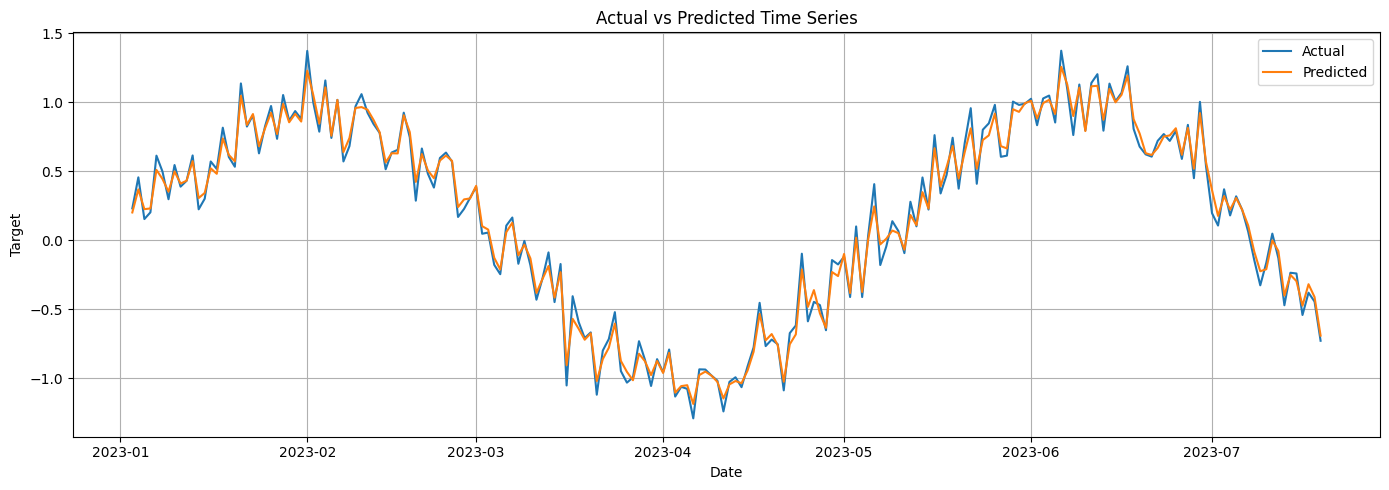

In [ ]:
#  train on all data and visualize
model.fit(X, y)
data['prediction'] = model.predict(X)

plt.figure(figsize=(14, 5))
plt.plot(data['timestamp'], data['target'], label='Actual')
plt.plot(data['timestamp'], data['prediction'], label='Predicted')
plt.title('Actual vs Predicted Time Series')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\Ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Ad\AppData\Local\Temp\ipykernel_25376\299984035.py:104: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
C:\Users\Ad\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


Test RMSE: 0.5565
Test MAE:  0.4494
Test MAPE: 425.68%


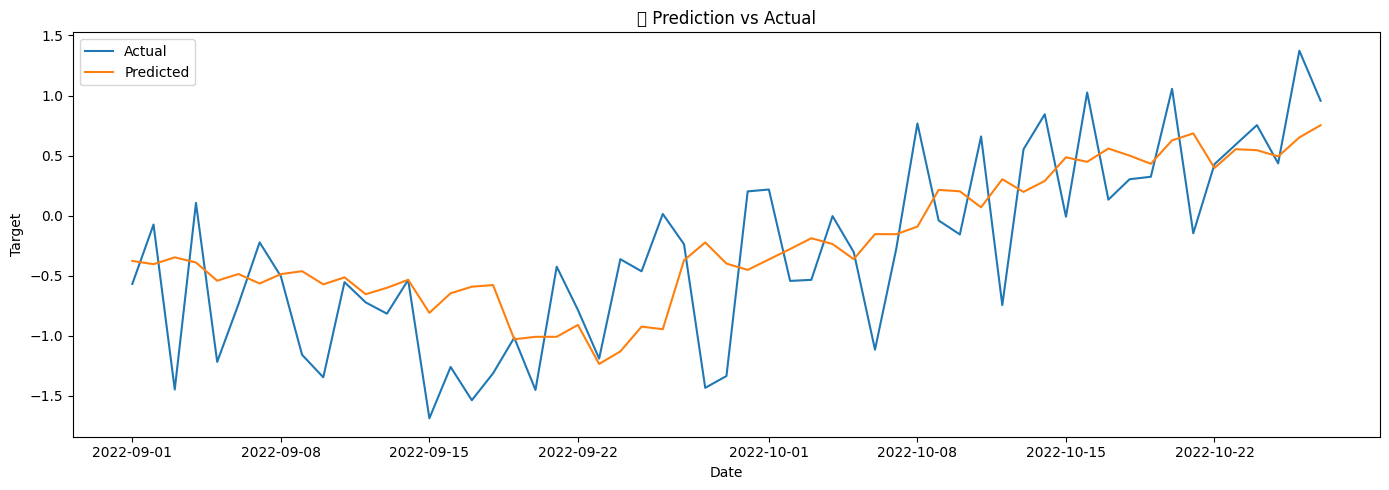

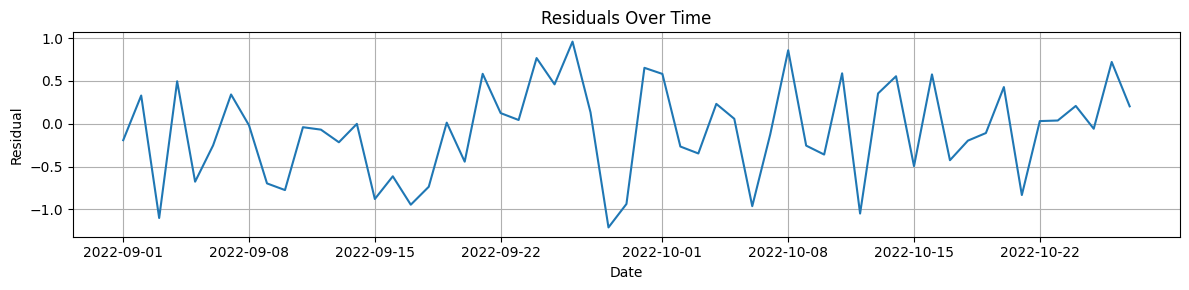

C:\Users\Ad\AppData\Local\Temp\ipykernel_25376\299984035.py:128: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\Ad\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


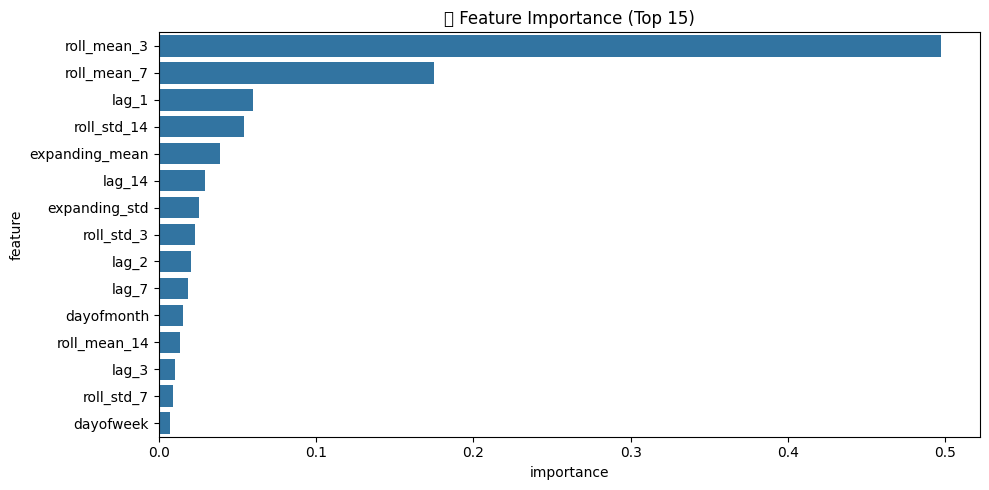

In [ ]:
# full 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler



n_days = 300
date_range = pd.date_range(start='2022-01-01', periods=n_days, freq='D')

data = pd.DataFrame({
    'timestamp': date_range,
    'target': np.sin(np.arange(n_days)/15) + 0.5*np.random.randn(n_days)
})

#  TS feature Engineering

df = data.copy()
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df['dayofmonth'] = df['timestamp'].dt.day
df['is_weekend'] = df['dayofweek'] >= 5

# lag features
for lag in [1, 2, 3, 7, 14]:
    df[f'lag_{lag}'] = df['target'].shift(lag)

# rolling mean and std
for window in [3, 7, 14]:
    df[f'roll_mean_{window}'] = df['target'].shift(1).rolling(window).mean()
    df[f'roll_std_{window}'] = df['target'].shift(1).rolling(window).std()

# expanding stats
df['expanding_mean'] = df['target'].expanding().mean().shift(1)
df['expanding_std'] = df['target'].expanding().std().shift(1)

# Drop NaNs
df = df.dropna().reset_index(drop=True)


# Train/Validation Split

features = [col for col in df.columns if col not in ['timestamp', 'target']]
X = df[features]
y = df['target']

# scale features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Final 20% as hold-out test
test_size = int(0.2 * len(X))
X_train, X_test = X_scaled[:-test_size], X_scaled[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# Model Training + Grid Search

tscv = TimeSeriesSplit(n_splits=3)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None]
}

grid = GridSearchCV(RandomForestRegressor(random_state=42),
                    param_grid, cv=tscv, scoring='neg_root_mean_squared_error',
                    n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_


# evaluation

def mape(y_true, y_pred):  # mean absolute percecntage error
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_pred = best_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mape_score = mape(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test MAPE: {mape_score:.2f}%")

# plot: Predictions vs Actual

plt.figure(figsize=(14, 5))
plt.plot(df['timestamp'][-test_size:], y_test, label='Actual')
plt.plot(df['timestamp'][-test_size:], y_pred, label='Predicted')
plt.title("🔍 Prediction vs Actual")
plt.xlabel("Date")
plt.ylabel("Target")
plt.legend()
plt.tight_layout()
plt.show()

# plot: Residuals
residuals = y_test - y_pred
plt.figure(figsize=(12, 3))
plt.plot(df['timestamp'][-test_size:], residuals)
plt.title("Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.grid(True)
plt.tight_layout()
plt.show()


# Feature Importance

importances = best_model.feature_importances_
feat_imp = pd.DataFrame({'feature': features, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=feat_imp.head(15), x='importance', y='feature')
plt.title("📈 Feature Importance (Top 15)")
plt.tight_layout()
plt.show()
